In [1]:
import torch as th
import torchvision.transforms as T #torchvision is kind of addition to pytorch that helps us with images and has a lot of images and datasets . Transforms helps with resize ,rotate, crop and pretty much everything we need for images pretraining
import requests # for loading the image
from PIL import Image, ImageDraw, ImageFont # importing tools from Python Image Library

In [2]:
model  = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained = True) # loading the facebook detr model from torch hub
model.eval() 
model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


In [25]:
model # the entire model having transformer, resnet.


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [17]:
# Standard Pytorch mean-std imput image normalisation
transform  = T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet standard mean , standard deviation and normalisation
])

#COCO datset class label
CLASSES = [
           'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [57]:
url = input() #https://i.ytimg.com/vi/vrlX3cwr3ww/maxresdefault.jpg

https://i.ytimg.com/vi/vrlX3cwr3ww/maxresdefault.jpg


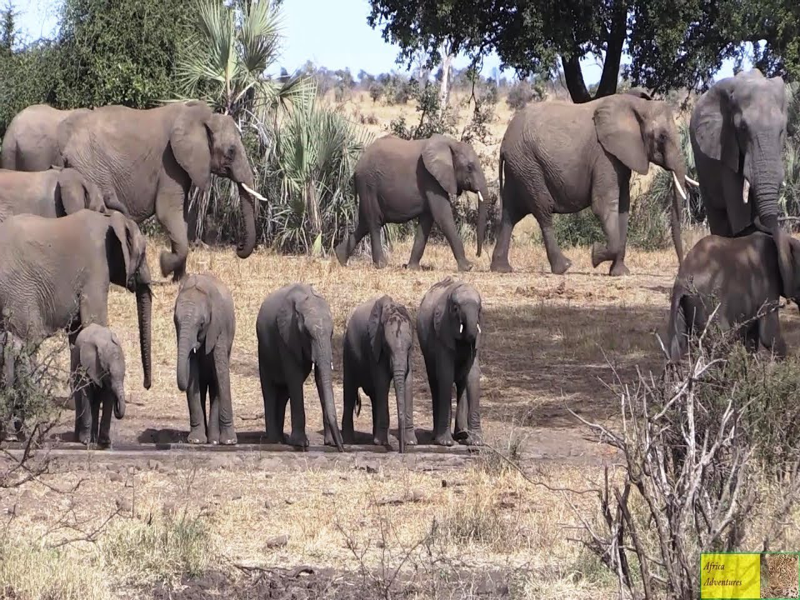

In [58]:
#(requests.get(url, stream = True) = this gives the bytes of the image
img = Image.open(requests.get(url, stream = True).raw).resize((800,600)).convert('RGB') # coco dataset is 640 by 480 but the model uses the resized data to be 800.
img

In [59]:
img_tens = transform(img).unsqueeze(0).cuda() ###unsqueezing the image to its first dimension to get batches.

In [60]:
with th.no_grad(): ## we dont need grad since we are using the pretrained model
    output = model(img_tens)

In [64]:
im2 =img.copy() #copying the image
drw = ImageDraw.Draw(im2) 
pred_logits = output['pred_logits'][0][: , : len(CLASSES)]
pred_boxes = output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15) #no of detection in the image.

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([15, 91])

In [65]:
# labelling the images and drawing the bounding boxes.
for logits , box in zip(pred_logits, pred_boxes):
    cls = logits.argmax()
    if cls >= len(CLASSES):
        continue
    label = CLASSES[cls]
    print(label)
    box = box.cpu() * th.Tensor([800, 600, 800, 600])
    x, y, w, h = box
    x0, x1 = x-w//2, x+w//2
    y0, y1 = y-h//2, y+h//2
    drw.rectangle([x0, y0, x1, y1], outline = 'red', width = 5)
    drw.text((x,y), label, fill = 'white') 

elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant
elephant


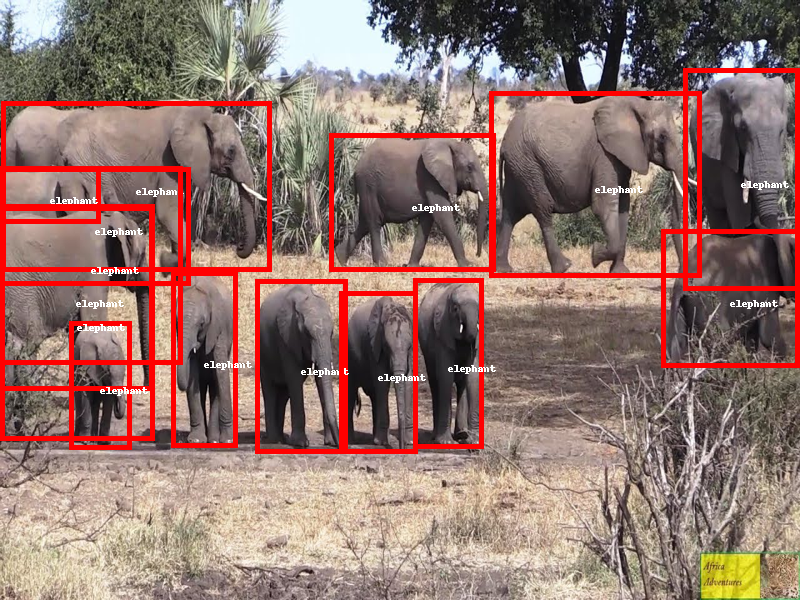

In [66]:
im2

In [28]:
url = input()


https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260


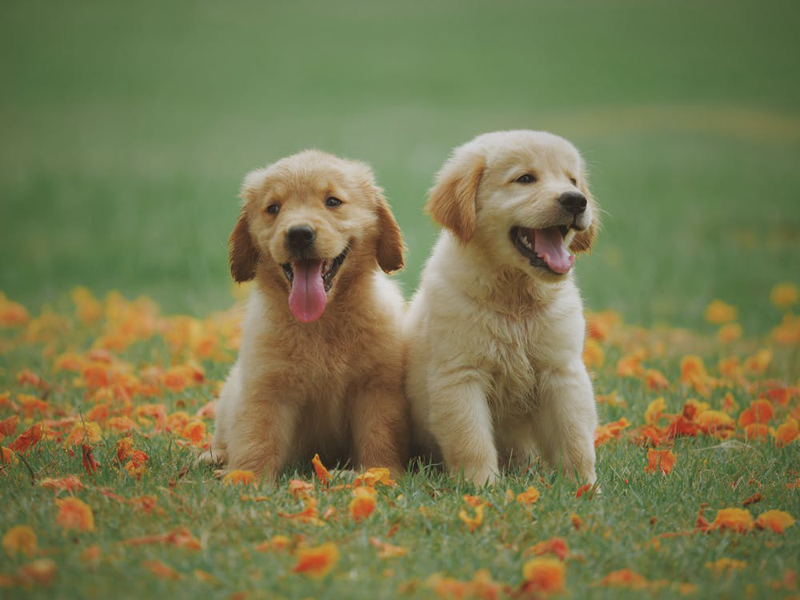

In [29]:
img = Image.open(requests.get(url, stream = True).raw).resize((800,600)).convert('RGB')
img

In [40]:
print(type(img)) # checking the type of image

<class 'PIL.Image.Image'>


In [39]:
transform(img) # transforming the image to its tensor.

tensor([[[-0.8335, -0.8335, -0.8335,  ..., -0.8678, -0.8849, -0.8849],
         [-0.8335, -0.8335, -0.8335,  ..., -0.8678, -0.8849, -0.8849],
         [-0.8335, -0.8335, -0.8335,  ..., -0.8678, -0.8849, -0.8849],
         ...,
         [-0.7993, -0.8335, -0.8678,  ..., -0.1486, -0.1143, -0.0972],
         [-0.7822, -0.8164, -0.8507,  ..., -0.1143, -0.0629, -0.0458],
         [-0.7822, -0.7993, -0.8507,  ..., -0.0801, -0.0287, -0.0116]],

        [[-0.3725, -0.3725, -0.3725,  ..., -0.4076, -0.4251, -0.4251],
         [-0.3725, -0.3725, -0.3725,  ..., -0.4076, -0.4251, -0.4251],
         [-0.3725, -0.3725, -0.3725,  ..., -0.4076, -0.4251, -0.4251],
         ...,
         [-0.4951, -0.5301, -0.6001,  ..., -0.4076, -0.3725, -0.3550],
         [-0.4776, -0.5301, -0.5826,  ..., -0.4076, -0.3725, -0.3725],
         [-0.4776, -0.5126, -0.5826,  ..., -0.4076, -0.3725, -0.3550]],

        [[-0.7936, -0.7936, -0.7936,  ..., -0.8284, -0.8458, -0.8458],
         [-0.7936, -0.7936, -0.7936,  ..., -0

In [41]:
transform(img).unsqueeze(0).shape ##unsqueezing the image to its first dimension to get batches.

torch.Size([1, 3, 600, 800])

In [31]:
img_tens = transform(img).unsqueeze(0).cuda() #unsqueezing the image to its first dimension to get batches.

In [32]:
with th.no_grad():  # we dont need grad since we are using the pretrained model
    output = model(img_tens)

In [42]:
output # output is a dictionary with  class labels and bounding boxes

{'pred_boxes': tensor([[[0.3874, 0.5207, 0.2705, 0.5591],
          [0.5093, 0.5163, 0.4992, 0.5911],
          [0.3799, 0.5064, 0.2551, 0.5268],
          [0.5069, 0.5191, 0.4950, 0.6059],
          [0.5028, 0.5221, 0.5002, 0.5918],
          [0.6333, 0.5201, 0.2507, 0.6138],
          [0.5097, 0.5254, 0.4824, 0.5866],
          [0.5113, 0.5217, 0.4893, 0.5948],
          [0.4866, 0.5261, 0.4375, 0.5898],
          [0.3770, 0.5144, 0.2527, 0.5326],
          [0.4814, 0.5240, 0.4365, 0.5641],
          [0.5079, 0.5241, 0.4799, 0.5932],
          [0.4132, 0.5257, 0.3916, 0.5698],
          [0.4786, 0.5295, 0.4253, 0.5785],
          [0.6704, 0.5177, 0.3452, 0.6139],
          [0.4496, 0.5253, 0.3860, 0.5794],
          [0.3959, 0.5185, 0.2697, 0.5559],
          [0.5230, 0.5265, 0.4721, 0.5913],
          [0.7111, 0.3838, 0.0410, 0.0421],
          [0.4311, 0.5249, 0.3465, 0.5767],
          [0.5069, 0.5284, 0.4843, 0.5907],
          [0.6712, 0.3208, 0.1430, 0.1253],
          [0.4217,

In [44]:
output['pred_boxes']

tensor([[[0.3874, 0.5207, 0.2705, 0.5591],
         [0.5093, 0.5163, 0.4992, 0.5911],
         [0.3799, 0.5064, 0.2551, 0.5268],
         [0.5069, 0.5191, 0.4950, 0.6059],
         [0.5028, 0.5221, 0.5002, 0.5918],
         [0.6333, 0.5201, 0.2507, 0.6138],
         [0.5097, 0.5254, 0.4824, 0.5866],
         [0.5113, 0.5217, 0.4893, 0.5948],
         [0.4866, 0.5261, 0.4375, 0.5898],
         [0.3770, 0.5144, 0.2527, 0.5326],
         [0.4814, 0.5240, 0.4365, 0.5641],
         [0.5079, 0.5241, 0.4799, 0.5932],
         [0.4132, 0.5257, 0.3916, 0.5698],
         [0.4786, 0.5295, 0.4253, 0.5785],
         [0.6704, 0.5177, 0.3452, 0.6139],
         [0.4496, 0.5253, 0.3860, 0.5794],
         [0.3959, 0.5185, 0.2697, 0.5559],
         [0.5230, 0.5265, 0.4721, 0.5913],
         [0.7111, 0.3838, 0.0410, 0.0421],
         [0.4311, 0.5249, 0.3465, 0.5767],
         [0.5069, 0.5284, 0.4843, 0.5907],
         [0.6712, 0.3208, 0.1430, 0.1253],
         [0.4217, 0.5285, 0.3339, 0.5709],
         [0

In [45]:
output['pred_boxes'].shape

torch.Size([1, 100, 4])

In [49]:
print(output['pred_boxes'][0].shape)
print(output['pred_logits'][0].shape)
print(len(CLASSES))

torch.Size([100, 4])
torch.Size([100, 92])
91


In [ ]:
# for each of the pred_logits we want to predict which class it belongs to

In [52]:
output['pred_logits'][0].argmax(-1)

tensor([91, 91, 91, 91, 91, 18, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 18, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        91, 91, 91, 91, 91, 91, 91, 91, 91, 91], device='cuda:0')

In [43]:
im2 =img.copy()
drw = ImageDraw.Draw(im2) #drawing the boundary(bounding box) on the image
pred_logits = output['pred_logits'][0][: , : len(CLASSES)]
pred_boxes = output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(2)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([2, 91])

In [37]:
for logits , box in zip(pred_logits, pred_boxes):
    cls = logits.argmax()
    if cls >= len(CLASSES):
        continue
    label = CLASSES[cls]
    print(label)  # detecting the label of class for the image.
    box = box.cpu() * th.Tensor([800, 600, 800, 600]) #scaling the box
    x, y, w, h = box
    x0, x1 = x-w//2, x+w//2
    y0, y1 = y-h//2, y+h//2
    drw.rectangle([x0, y0, x1, y1], outline = 'red', width = 5) #drawing the rectangle box
    drw.text((x,y), label, fill = 'white') 

dog
dog


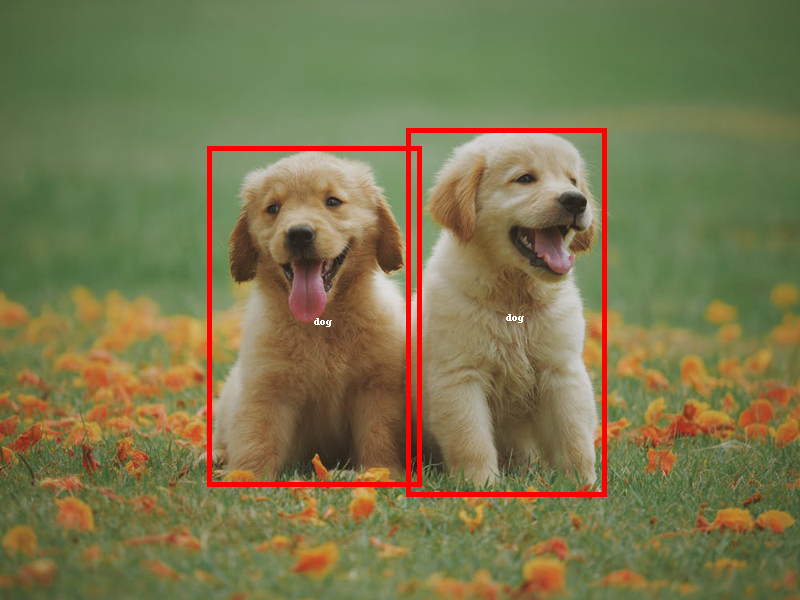

In [38]:
im2